# POSITION CONTROL BY ARTIFICIAL NEURAL NETWORKS

This project is performed to control the angular position of a permanent magnet electric motor.

# 1. Import Required Libraries, Set Hyperparameters and Define Reference Position

In [12]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
from timeit import default_timer as timer
from datetime import datetime
# %matplotlib widget
import helper_functions as hp
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

IN_FEATURES = 1
OUT_FEATURES = 1
HIDDEN_UNITS = 128
LEARNING_RATE = 0.001
DT = 0.001
EPOCHS = 10001


# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using device: {device}")

hp.set_seeds()

Using device: cpu
Manual seed is set as 42.


## 1.1. Generate Reference and Test Data

In [13]:
REF_CALC_TIME = 20 # seconds
REFERENCE_POSITION_AMPLITUDE = [30,20,-30,100,-5,-25,0] # radians
REF_DURATION = [0.1,0.2,0.25,0.1,0.15,0.1,0.1]
ref_size = int(REF_CALC_TIME/DT)

TEST_CALC_TIME = 10 # seconds
TEST_POSITION_AMPLITUDE = [30,20,-50,40,10] # radians
TEST_DURATION = [0.1,0.3,0.2,0.25,0.15]
test_size = int(TEST_CALC_TIME/DT)

# Generate reference position data
reference_position = torch.Tensor().to(device)
for i in range(len(REFERENCE_POSITION_AMPLITUDE)):
    reference_position = torch.cat((reference_position, 
                                    REFERENCE_POSITION_AMPLITUDE[i]*torch.ones(size=[int(ref_size*REF_DURATION[i]),1],device=device)), 0)


# Generate test position data
test_position = torch.Tensor().to(device)
for i in range(len(TEST_POSITION_AMPLITUDE)):
    test_position = torch.cat((test_position, 
                                    TEST_POSITION_AMPLITUDE[i]*torch.ones(size=[int(test_size*TEST_DURATION[i]),1],device=device)), 0)

# 2. PM Electric Motor System

In [14]:
def motor(theta_current, # Current angular position
          theta_dot_current, # Current angular velocity
          Ia_current, # Current inductive current
          Vdc_current, # DC voltage applid on the motor
          dt, # Differentia time increament
          ):
    Ra = 1.2
    La = 1.4e-3
    Ka = 0.055
    Kt = Ka
    J = 0.0005
    B = 0.01*J
    
    if Vdc_current > 100:
        Vdc_current = 100
        
    elif Vdc_current < -100:
        Vdc_current = -100

    theta_forward = theta_current+dt*theta_dot_current
    theta_dot_forward = theta_dot_current+dt*(-B*theta_dot_current+Kt*Ia_current)/J
    I_forward = Ia_current+dt*(-Ka*theta_dot_current-Ra*Ia_current+Vdc_current)/La
    
    return theta_forward, theta_dot_forward, I_forward


In [15]:
def plot_response(theta, theta_dot, Ia, Vdc, time, ref = None):
    plt.figure(); #figsize=(10,6)
    plt.plot(time,Vdc,label="DC Voltage [V]")
    plt.plot(time,theta,label="Angular Position of Motor [rad]")
    plt.plot(time,Ia,label="Alternative Current [A]")
    plt.plot(time,theta_dot,label="Angular Velocity [rad/s]")

    if ref is not None:
        plt.plot(time,ref,label="Reference Position [rad]")

    plt.title("System Response for an Arbitrary Sinusoidal Input")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.legend();

## 2.1. Check System Response for Sinusoidal Input

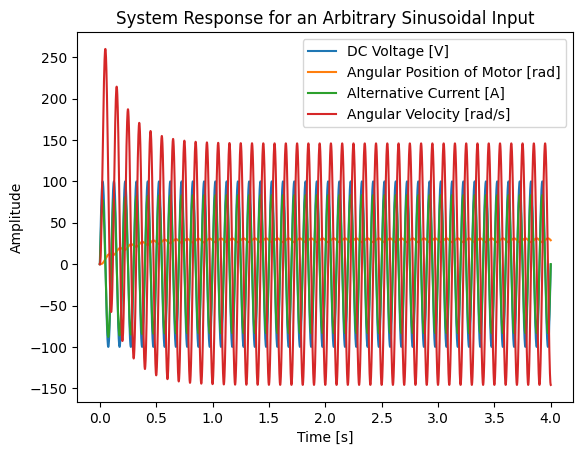

In [16]:
plot_time = 4
plot_dt = 0.0001
plot_max_iter = int(plot_time/plot_dt)

plot_theta = np.zeros(plot_max_iter)
plot_theta_dot = np.zeros(plot_max_iter)
plot_Ia = np.zeros(plot_max_iter)
plot_t=np.arange(0,4,plot_dt)

plot_Vdc= 100*np.sin(2*np.pi*10*plot_t)

for i in range(plot_max_iter-1):
    plot_theta[i+1], plot_theta_dot[i+1], plot_Ia[i+1] = motor(plot_theta[i], 
                                                               plot_theta_dot[i],
                                                               plot_Ia[i],
                                                               plot_Vdc[i],
                                                               plot_dt)

plot_response(plot_theta,plot_theta_dot,plot_Ia,plot_Vdc,plot_t)

# 3. Neural Network Controller Model Setup

In [17]:
# Subclass nn.Module to make our model
class NNControllerModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.layer = nn.Sequential(nn.Linear(in_features=input_features, out_features=hidden_units),
                                   nn.ReLU(),
                                   nn.Linear(in_features=hidden_units, out_features=hidden_units),
                                   nn.ReLU(),
                                   nn.Linear(in_features=hidden_units, out_features=output_features),
                                #    nn.Tanh()
                                  )
    
    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output = self.layer(x)
        if output > 100:
            output = 100
        elif output < -100:
            output = -100
        return output

model_1 = NNControllerModel(input_features=1, 
                            output_features=1, 
                            hidden_units=32).to(device)

# 4. Loss Function and Optimizer Setup

In [18]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=LEARNING_RATE)

# 5. Perform the Training

In [19]:
train_time_start = timer()

for epoch in tqdm(range(EPOCHS)):
    
    epoch_calc_start = timer()

    model_1.train()
    Vdc_ref = torch.zeros(size=[ref_size,OUT_FEATURES],device=device)
    Ia_ref = torch.zeros(size=[ref_size,1],device=device)
    theta_ref = torch.zeros(size=[ref_size,1],device=device)
    theta_dot_ref = torch.zeros(size=[ref_size,1],device=device)
    error_ref = torch.zeros(size=[ref_size,IN_FEATURES],device=device)

    for i in range(ref_size-1):
        error_ref = reference_position - theta_ref
        Vdc_ref[i] = model_1(error_ref[i])
        theta_ref[i+1], theta_dot_ref[i+1], Ia_ref[i+1] = motor(theta_current=theta_ref[i],
                                                                theta_dot_current=theta_dot_ref[i],
                                                                Ia_current=Ia_ref[i],
                                                                Vdc_current=Vdc_ref[i],
                                                                dt=DT)

    loss = loss_fn(theta_ref, reference_position)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    epoch_calc_time = timer()- epoch_calc_start
    
    # Evaluate Model
    model_1.eval()
    with torch.inference_mode():
        Vdc_test = torch.zeros(size=[test_size,OUT_FEATURES],device=device)
        Ia_test = torch.zeros(size=[test_size,1],device=device)
        theta_test = torch.zeros(size=[test_size,1],device=device)
        theta_dot_test = torch.zeros(size=[test_size,1],device=device)
        error_test = torch.zeros(size=[test_size,IN_FEATURES],device=device)

        for i in range(test_size-1):
            error_test = test_position - theta_test
            Vdc_test[i] = model_1(error_test[i])
            theta_test[i+1], theta_dot_test[i+1], Ia_test[i+1] = motor(theta_current=theta_test[i],
                                                                        theta_dot_current=theta_dot_test[i],
                                                                        Ia_current=Ia_test[i],
                                                                        Vdc_current=Vdc_test[i],
                                                                        dt=DT)

        loss_eval = loss_fn(theta_test, test_position)
        writer.add_scalars("Loss", {"Train Loss":loss,
                                    "Test Loss":loss_eval}, epoch)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.3f} | Test loss: {loss_eval:.3f}")
        print(f"Single Epoch Training Time: {epoch_calc_time:.3f} s\n")

print(f"Total Training Time: {timer()-train_time_start:.3f} s")
writer.close()

  0%|          | 0/10001 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 16575.842 | Test loss: 8116.904
Single Epoch Training Time: 10.922 s

Epoch: 10 | Train loss: 6.555 | Test loss: 7.994
Single Epoch Training Time: 15.477 s

Epoch: 20 | Train loss: 6.443 | Test loss: 7.848
Single Epoch Training Time: 15.191 s

Epoch: 30 | Train loss: 6.395 | Test loss: 7.740
Single Epoch Training Time: 15.104 s

Epoch: 40 | Train loss: 6.350 | Test loss: 7.632
Single Epoch Training Time: 15.466 s

Epoch: 50 | Train loss: 6.306 | Test loss: 7.542
Single Epoch Training Time: 15.353 s

Epoch: 60 | Train loss: 6.264 | Test loss: 7.465
Single Epoch Training Time: 15.756 s

Epoch: 70 | Train loss: 6.225 | Test loss: 7.397
Single Epoch Training Time: 15.636 s

Epoch: 80 | Train loss: 6.191 | Test loss: 7.333
Single Epoch Training Time: 15.837 s

Epoch: 90 | Train loss: 6.160 | Test loss: 7.272
Single Epoch Training Time: 14.971 s

Epoch: 100 | Train loss: 6.128 | Test loss: 7.216
Single Epoch Training Time: 15.214 s

Epoch: 110 | Train loss: 6.097 | Tes

KeyboardInterrupt: 

# 6. Evaluate Trained Model and Visualize the System Response

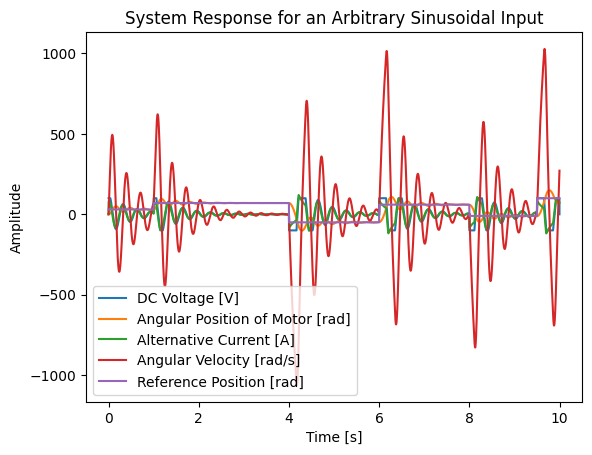

In [24]:
# Generate new test position data
VAL_CALC_TIME = 10 # seconds
VAL_POSITION_AMPLITUDE = [30,70,-50,60,-10,100] # radians
VAL_DURATION = [0.1,0.3,0.2,0.20,0.15,0.05]
val_size = int(VAL_CALC_TIME/DT)

val_position = torch.Tensor().to(device)
for i in range(len(VAL_POSITION_AMPLITUDE)):
    val_position = torch.cat((val_position, 
                                    VAL_POSITION_AMPLITUDE[i]*torch.ones(size=[int(test_size*VAL_DURATION[i]),1],device=device)), 0)

model_1.eval()
with torch.inference_mode():
    Vdc_val = torch.zeros(size=[test_size,OUT_FEATURES],device=device)
    Ia_val = torch.zeros(size=[test_size,1],device=device)
    theta_val = torch.zeros(size=[test_size,1],device=device)
    theta_dot_val = torch.zeros(size=[test_size,1],device=device)
    error_val = torch.zeros(size=[test_size,IN_FEATURES],device=device)

    for i in range(val_size-1):
        error_val = val_position - theta_val
        Vdc_val[i] = model_1(error_val[i])
        theta_val[i+1], theta_dot_val[i+1], Ia_val[i+1] = motor(theta_current=theta_val[i],
                                                                    theta_dot_current=theta_dot_val[i],
                                                                    Ia_current=Ia_val[i],
                                                                    Vdc_current=Vdc_val[i],
                                                                    dt=DT)
plot_response(theta_val.cpu(),theta_dot_val.cpu(),Ia_val.cpu(),Vdc_val.cpu(),np.arange(0,VAL_CALC_TIME,DT),val_position.cpu())


# 7. Save the Model

In [25]:
date_time = datetime.now().strftime("%Y%m%d_%H%M%S")

hp.save_model(model=model_1,model_name="Saved_Model_"+date_time)

Saving model to: Saved_Models/Saved_Model_20221227_094056
